<a href="https://colab.research.google.com/github/ShaanHossain/NLPFinalProject/blob/master/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
# from google.colab import drive # import drive from google colab
# ROOT = "/content/drive"     # default location for the drive
# print(ROOT)                 # print content of ROOT (Optional
# drive.mount(ROOT)           # we mount the google drive at /content/drive

# 1. Importing Dependencies

In [2]:
#import files
import sys
from csv import reader
from typing import List
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
import numpy as np
import inflect
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Initial Setup - Defining the driving variables

In [3]:
# Determines which dataset use and how much to use :
# HateSpeech: Column-0 : Sentence, Column-1 : Label [noHate-0, Hate-1]
# either 'HateSpeech' or 'KaggleTwitter' or 'TDavidson'
dataset_to_use = "HateSpeech"
dataset_percentage = 100  # percentage range 1 to 100

# Initializes file path, column of csv file to parse and
# the delimiter for parsing
training_file = ""
test_file = ""
sentence_column_to_parse = None
label_column_to_parse = None
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
delimiter = ","
if dataset_to_use == "HateSpeech":
    training_file = "datasets/hate-speech/train.txt"
    test_file = "datasets/hate-speech/test.txt"
    delimiter = "\t"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "KaggleTwitter":
    training_file = "datasets/kaggle-twitter/train.csv"
    test_file = "datasets/kaggle-twitter/test.csv"
    sentence_column_to_parse = 2
    label_column_to_parse = 1
elif dataset_to_use == "TDavidson":
    training_file = "datasets/t-davidson-hate-speech/labeled_data.csv"
    # TODO: Update test path for this dataset
    # test_file = "datasets/kaggle-twitter/test.csv"
    sentence_column_to_parse = 6
    label_column_to_parse = 2
else:
    print("Invalid Dataset specified")
    sys.exit(1)

# 1. Preprocessing the Data

### Seven tasks are done as part of this:
  - lower word case
  - remove stopwords
  - remove punctuation
  - convert numbers to texts
  - perform stemming
  - Add - \<s> and \</s> for every sentence

In [4]:
def replace_numbers(sentence:List[str]) -> List[str]:
    """Replace all interger occurrences in list of tokenized words
    with textual representation"""
    p = inflect.engine()
    new_words = []  
    for word in sentence.split():
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def stem_words(sentence: List[str]) -> List[str]:
    """Stems the given sentence

    Args:
        sentence (list): words to be stemmed

    Returns:
        str: stemmed sentence
    """
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(lancaster.stem(word))
    return " ".join(stemmed_words)

def preprocessing(running_lines: List[str]) -> List[str]:
    """This function takes in the running test and return back the
    preprocessed text. Six tasks are done as part of this:
      1. lower word case
      2. remove stopwords
      3. remove punctuation
      4. convert numbers to texts
      5. perform stemming

    Args:
        sentence (List[str]): list of lines

    Returns:
        List[str]: list of sentences which are processed
    """
    preprocessed_lines = []
    tokenizer = RegexpTokenizer(r"\w+")
    for line in running_lines:
        # lower case
        lower_case_data = line.lower()
        # remove stop words
        data_without_stop_word = remove_stopwords(lower_case_data)
        # remove punctunation
        data_without_punct = strip_punctuation(data_without_stop_word)
        # replace numbers '1' to 'one'
        processed_data = replace_numbers(data_without_punct)
        # stem words
        processed_data = stem_words(processed_data)
        # add start and stop tags
        # processed_data.insert(0, "<s>")
        # processed_data.append("</s>")
        preprocessed_lines.append(processed_data)
    return preprocessed_lines

# 2. Parsing the data

In [5]:
def parse_data(training_file_path: str, percentage: int,
               sentence_column: int, label_column: int,
               delimit: str):
    """This function is used to parse input lines
    and returns a the provided percent of data.

    Args:
        lines (List[str]): list of lines
        percentage (int): percent of the dataset needed
        sentence_column (int): sentence column from the dataset
        label_column (int): label column from the dataset
        delimit (str): delimiter
    Returns:
        List[str], List[str]: examples , labels -> [percentage of dataset]
    """
    percentage_sentences = []
    percentage_labels = []
    with open(training_file_path, "r", encoding="utf8",
              errors="ignore") as csvfile:
        read_sentences = []
        label_sentences = []
        csv_reader = reader(csvfile, delimiter=delimit)
        # skipping header
        header = next(csv_reader)
        # line_length = len(list(csv_reader_copy))
        if header is not None:
            for row in csv_reader:
                read_sentences.append(row[sentence_column])
                label_sentences.append(int(row[label_column]))
        end_of_data = int(len(read_sentences) * percentage * .01)
        percentage_sentences = read_sentences[0:end_of_data]
        percentage_labels = label_sentences[0:end_of_data]
    return percentage_sentences, percentage_labels

In [6]:
train_sentences, train_labels = parse_data(training_file,
                                           dataset_percentage,
                                           sentence_column_to_parse,
                                           label_column_to_parse,
                                           delimiter)
# parse and preprocess the data
processed_train_sentences = preprocessing(train_sentences)
# verify the processed sentences
# for sentence in sentences:
#     print(sentence)
# This is the baseline classifier
print(
    f"Performing Improved - BiLSTM on {dataset_to_use}"
    f" with {dataset_percentage} % data ")

Performing Improved - BiLSTM on HateSpeech with 100 % data 


# 3. Building Model

### 3.1 Generating word embeddings

For this step, we intend to use the Keras library to build a recurrent neural network based on bidirectional LSTMs. The model will take word embeddings as input so we will use pre-trained GloVe embeddings to make the embedding dictionary.

In [7]:
def convert_sentence_word_embeddings(X_train_sentences:List[str]):
    """Converts the sentences into word embeddings.

    Args:
        X_train_sentences (List[str]): list of training sentences

    Returns:
        tuple: word embeddings for each sentence, vocab size and embedding dictionary
    """
    tokenizer = Tokenizer()
    text = np.array(X_train_sentences)
    tokenizer.fit_on_texts(X_train_sentences)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    embeddings_dict = {}
    file_embeddings = open("utils/glove.twitter.27B.50d.txt", encoding="utf8")
    for embedding_line in file_embeddings:
        values = embedding_line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
    file_embeddings.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (text, word_index, embeddings_dict)

In [8]:
X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(processed_train_sentences)
embedding_size = len(X_train_Glove_s[0])
## Check function
# x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
# X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(x_train_sample)
# print("\n X_train_Glove_s \n ", X_train_Glove_s)
# print("\n Word index of the word testing is : ", word_index_s["industry"])
# print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 3951 unique tokens.
Total 1193514 word vectors.


### 3.2 Defining function to create model

In [9]:
import keras
import tensorflow as tf
import optuna
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
def build_bilstm(
    word_index, 
    embeddings_dict,   
    embedding_dim,
    num_hidden_layers,
    num_nodes_per_hidden_layer,
    num_nodes_final_fc_layer,
    input_dropout,
    recurrent_dropout,
    output_dropout,
    learning_rate,
    max_sequence_length, 
    nclasses=2
    ):

    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " embedding_dim is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,num_hidden_layers):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, return_sequences=True, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(output_dropout))
    model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
    model.add(Dropout(output_dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(num_nodes_final_fc_layer, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # keras.optimizers.ada
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
    return model

In [56]:
print("Building Model!")

# The ones we want to look at:
# 1. Number of BiLSTM layers
# 2. Number of nodes per BiLSTM layer
# 4. Learning rate
# 5. Embedding dimension

def objective(trial):

    model = build_bilstm(
        word_index=word_index_s, 
        embeddings_dict=embeddings_dict_s, 
        embedding_dim=50, #50 
        num_hidden_layers=3,
        # num_hidden_layers=trial.suggest_int("num_hidden_layers", 1, 5, step=1), #3 
        num_nodes_per_hidden_layer=8,
        # num_nodes_per_hidden_layer=trial.suggest_int("num_nodes_per_hidden_layer", 4, 64, step=2), #32
        num_nodes_final_fc_layer=64, #256
        input_dropout=0,
        recurrent_dropout=.2,
        output_dropout=.5,
        learning_rate=trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        max_sequence_length=embedding_size)
    # model.summary()

    X_train, X_test, y_train, y_test = train_test_split(X_train_Glove_s, train_labels, test_size = 0.2)
    data_history = model.fit(np.array(X_train), np.array(y_train),
                           validation_data=(np.array(X_test),np.array(y_test)),
                           epochs=5,
                           batch_size=128,
                           verbose=1)

    trial.set_user_attr("loss", data_history.history['loss'])
    trial.set_user_attr("accuracy", data_history.history['accuracy'])
    
    score = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
    return score[1]

Building Model!


In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-10 23:27:21,945] A new study created in memory with name: no-name-a97bd181-5364-4df9-b5fb-f50b05b0d782


Epoch 1/3
12/12 [==============================] - 10s 373ms/step - loss: 0.6744 - accuracy: 0.5732 - val_loss: 0.6248 - val_accuracy: 0.6475
Epoch 2/3
12/12 [==============================] - 4s 319ms/step - loss: 0.5416 - accuracy: 0.7379 - val_loss: 0.6161 - val_accuracy: 0.7180
Epoch 3/3
12/12 [==============================] - 4s 325ms/step - loss: 0.3715 - accuracy: 0.8595 - val_loss: 0.6581 - val_accuracy: 0.7128


[I 2021-12-10 23:27:43,826] Trial 0 finished with value: 0.9261437654495239 and parameters: {'lr': 0.012813980648713183}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 393ms/step - loss: 0.6953 - accuracy: 0.4908 - val_loss: 0.6940 - val_accuracy: 0.4674
Epoch 2/3
12/12 [==============================] - 4s 335ms/step - loss: 0.6950 - accuracy: 0.4830 - val_loss: 0.6927 - val_accuracy: 0.4700
Epoch 3/3
12/12 [==============================] - 4s 312ms/step - loss: 0.6913 - accuracy: 0.5183 - val_loss: 0.6911 - val_accuracy: 0.5431


[I 2021-12-10 23:28:05,987] Trial 1 finished with value: 0.5738562345504761 and parameters: {'lr': 0.00032432107044416534}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 368ms/step - loss: 0.6945 - accuracy: 0.5007 - val_loss: 0.6929 - val_accuracy: 0.4804
Epoch 2/3
12/12 [==============================] - 4s 314ms/step - loss: 0.6923 - accuracy: 0.5111 - val_loss: 0.6948 - val_accuracy: 0.4543
Epoch 3/3
12/12 [==============================] - 4s 321ms/step - loss: 0.6882 - accuracy: 0.5359 - val_loss: 0.6932 - val_accuracy: 0.4491


[I 2021-12-10 23:28:28,110] Trial 2 finished with value: 0.5183006525039673 and parameters: {'lr': 0.00033868092589924015}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 398ms/step - loss: 0.6892 - accuracy: 0.5379 - val_loss: 0.6701 - val_accuracy: 0.5901
Epoch 2/3
12/12 [==============================] - 4s 322ms/step - loss: 0.6537 - accuracy: 0.6275 - val_loss: 0.6284 - val_accuracy: 0.6501
Epoch 3/3
12/12 [==============================] - 4s 337ms/step - loss: 0.5867 - accuracy: 0.7007 - val_loss: 0.5773 - val_accuracy: 0.7154


[I 2021-12-10 23:28:50,698] Trial 3 finished with value: 0.7594771385192871 and parameters: {'lr': 0.0031935404904863}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 373ms/step - loss: 0.6957 - accuracy: 0.5150 - val_loss: 0.6919 - val_accuracy: 0.5091
Epoch 2/3
12/12 [==============================] - 4s 322ms/step - loss: 0.6927 - accuracy: 0.5190 - val_loss: 0.6890 - val_accuracy: 0.5718
Epoch 3/3
12/12 [==============================] - 4s 324ms/step - loss: 0.6904 - accuracy: 0.5359 - val_loss: 0.6862 - val_accuracy: 0.5196


[I 2021-12-10 23:29:12,734] Trial 4 finished with value: 0.5444444417953491 and parameters: {'lr': 0.0007290168647130788}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 381ms/step - loss: 0.7110 - accuracy: 0.5118 - val_loss: 0.6810 - val_accuracy: 0.5901
Epoch 2/3
12/12 [==============================] - 4s 329ms/step - loss: 0.6704 - accuracy: 0.5758 - val_loss: 0.5804 - val_accuracy: 0.7154
Epoch 3/3
12/12 [==============================] - 4s 342ms/step - loss: 0.5335 - accuracy: 0.7542 - val_loss: 0.5449 - val_accuracy: 0.7546


[I 2021-12-10 23:29:35,450] Trial 5 finished with value: 0.8797385692596436 and parameters: {'lr': 0.03806164314597803}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 387ms/step - loss: 0.6943 - accuracy: 0.4863 - val_loss: 0.6929 - val_accuracy: 0.4752
Epoch 2/3
12/12 [==============================] - 4s 341ms/step - loss: 0.6923 - accuracy: 0.5216 - val_loss: 0.6921 - val_accuracy: 0.4700
Epoch 3/3
12/12 [==============================] - 4s 337ms/step - loss: 0.6912 - accuracy: 0.5235 - val_loss: 0.6913 - val_accuracy: 0.5744


[I 2021-12-10 23:29:57,993] Trial 6 finished with value: 0.6052287817001343 and parameters: {'lr': 0.00033224165638019883}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 388ms/step - loss: 0.6904 - accuracy: 0.5366 - val_loss: 0.6885 - val_accuracy: 0.6031
Epoch 2/3
12/12 [==============================] - 4s 322ms/step - loss: 0.6889 - accuracy: 0.5497 - val_loss: 0.6854 - val_accuracy: 0.6005
Epoch 3/3
12/12 [==============================] - 4s 325ms/step - loss: 0.6844 - accuracy: 0.5810 - val_loss: 0.6823 - val_accuracy: 0.5979


[I 2021-12-10 23:30:20,190] Trial 7 finished with value: 0.613725483417511 and parameters: {'lr': 0.00030095625558142653}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 10s 379ms/step - loss: 0.6917 - accuracy: 0.5255 - val_loss: 0.6922 - val_accuracy: 0.5770
Epoch 2/3
12/12 [==============================] - 4s 357ms/step - loss: 0.6916 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5640
Epoch 3/3
12/12 [==============================] - 4s 359ms/step - loss: 0.6920 - accuracy: 0.5373 - val_loss: 0.6920 - val_accuracy: 0.5692


[I 2021-12-10 23:30:43,203] Trial 8 finished with value: 0.584967315196991 and parameters: {'lr': 1.4547090773250597e-05}. Best is trial 0 with value: 0.9261437654495239.


Epoch 1/3
12/12 [==============================] - 11s 395ms/step - loss: 0.6929 - accuracy: 0.5484 - val_loss: 0.6882 - val_accuracy: 0.5091
Epoch 2/3
12/12 [==============================] - 4s 341ms/step - loss: 0.6284 - accuracy: 0.6549 - val_loss: 0.6150 - val_accuracy: 0.6919
Epoch 3/3
12/12 [==============================] - 4s 355ms/step - loss: 0.4510 - accuracy: 0.8157 - val_loss: 0.6448 - val_accuracy: 0.7154


[I 2021-12-10 23:31:06,057] Trial 9 finished with value: 0.8810457587242126 and parameters: {'lr': 0.012615633314471617}. Best is trial 0 with value: 0.9261437654495239.


Number of finished trials: 10
Best trial:
  Value: 0.9261437654495239
  Params: 
    lr: 0.012813980648713183


In [58]:
all_trials = study.get_trials();

print("  Params: ")
for trial in all_trials:
    print(trial.user_attrs["loss"])
    print(trial.user_attrs["accuracy"])
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

  Params: 
[0.6744340062141418, 0.5416145920753479, 0.3714517056941986]
[0.5732026100158691, 0.7379084825515747, 0.8594771027565002]
    lr: 0.012813980648713183
[0.6953386068344116, 0.694954514503479, 0.6912797689437866]
[0.49084967374801636, 0.4830065369606018, 0.5183006525039673]
    lr: 0.00032432107044416534
[0.6944527626037598, 0.6922848224639893, 0.6881822943687439]
[0.5006536245346069, 0.5111111402511597, 0.5359477400779724]
    lr: 0.00033868092589924015
[0.6891677379608154, 0.6537435054779053, 0.5867069363594055]
[0.5379084944725037, 0.6274510025978088, 0.700653612613678]
    lr: 0.0031935404904863
[0.6957341432571411, 0.6927295327186584, 0.6904497742652893]
[0.5150327086448669, 0.5189542770385742, 0.5359477400779724]
    lr: 0.0007290168647130788
[0.7110117673873901, 0.6704268455505371, 0.5335439443588257]
[0.5117647051811218, 0.5758169889450073, 0.7542483806610107]
    lr: 0.03806164314597803
[0.6943158507347107, 0.692280113697052, 0.6912041306495667]
[0.48627451062202454, 

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_Glove_s, train_labels, test_size = 0.2)
# data_history = model.fit(np.array(X_train), np.array(y_train),
#                            validation_data=(np.array(X_test),np.array(y_test)),
#                            epochs=20,
#                            batch_size=128,
#                            verbose=1)

0.012813980648713183


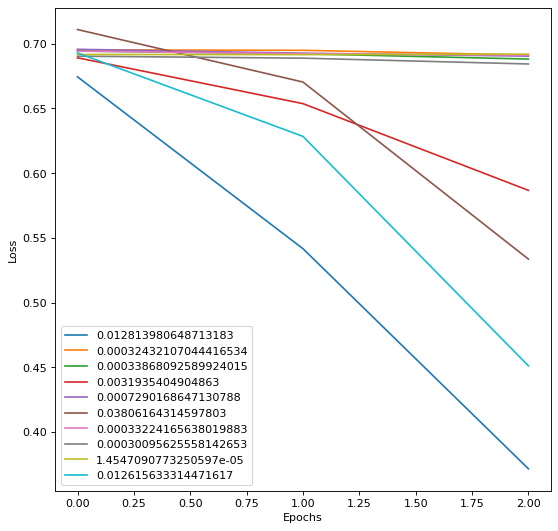

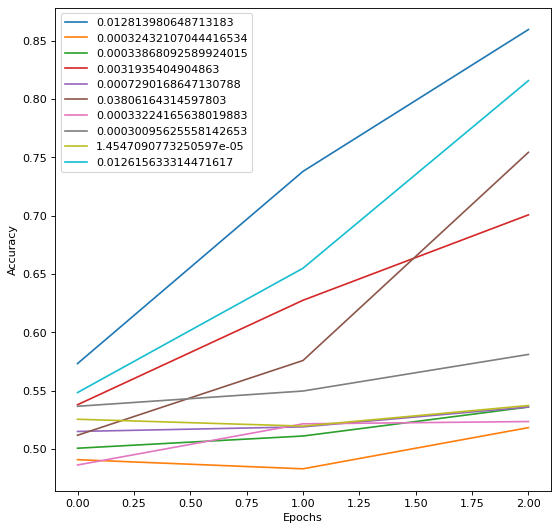

In [72]:
# def plot_graphs(axs, graph_index, history, string):
#     axs[graph_index].plot(history.history[string])
#     axs[graph_index].plot(history.history['val_'+string], '')
#     # axs[graph_index].xlabel("Epochs")
#     # axs[graph_index].ylabel(string)
#     axs[graph_index].set(xlabel="Epochs", ylabel=string)
#     axs[graph_index].legend([string, 'val_'+string])
#     # axs[graph_index].show()

# fig, axs = plt.subplots(2, figsize=(15, 15))
                        
# plot_graphs(axs, 0, data_history, 'accuracy')
# plot_graphs(axs, 1, data_history, 'loss')

from matplotlib.pyplot import figure

def plot_graphs_loss(trials):
    legends = []
    figure(figsize=(8, 8), dpi=80)
    for trial in trials:
        list_all_loss = trial.user_attrs['loss']
        legends.append(trial.params["lr"])
        plt.plot(list_all_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(legends)
    plt.savefig("loss.png")
    plt.show()

def plot_graphs_accuracy(trials):
    legends = []
    figure(figsize=(8, 8), dpi=80)
    for trial in trials:
        list_all_loss = trial.user_attrs['accuracy']
        legends.append(trial.params["lr"])
        plt.plot(list_all_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(legends)
    plt.savefig("accuracy.png")
    plt.show()

plot_graphs_loss(all_trials)
plot_graphs_accuracy(all_trials)